## kaggle : 
https://www.kaggle.com/c/dogs-vs-cats/data

In [11]:
import os, shutil
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras import models
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import numpy as np

In [12]:
small_dir = './datasets/cats_and_dogs_small'
train_dir = os.path.join(small_dir, 'train')
validation_dir = os.path.join(small_dir, 'validation')
test_dir = os.path.join(small_dir, 'test')

In [13]:

# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator_img = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator_img = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
for data_batch, labels_batch in train_generator_img:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


In [14]:

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## VGG16 + Full connect으로 학습

In [15]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [17]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [18]:
conv_base.trainable = False
print('conv_base를 동결한 후 훈련되는 가중치의 수:',  len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


In [19]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
#======================================= 장시간 주의 ==================================
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/10
100/100 - 251s - loss: 0.5518 - acc: 0.7295 - val_loss: 0.4197 - val_acc: 0.8450
Epoch 2/10
100/100 - 251s - loss: 0.4079 - acc: 0.8260 - val_loss: 0.3452 - val_acc: 0.8690
Epoch 3/10
100/100 - 250s - loss: 0.3567 - acc: 0.8500 - val_loss: 0.3058 - val_acc: 0.8840
Epoch 4/10
100/100 - 252s - loss: 0.3302 - acc: 0.8660 - val_loss: 0.2917 - val_acc: 0.8850
Epoch 5/10
100/100 - 253s - loss: 0.3092 - acc: 0.8750 - val_loss: 0.2789 - val_acc: 0.8950
Epoch 6/10
100/100 - 252s - loss: 0.2921 - acc: 0.8825 - val_loss: 0.2657 - val_acc: 0.8950
Epoch 7/10
100/100 - 253s - loss: 0.2745 - acc: 0.8945 - val_loss: 0.2599 - val_acc: 0.8970
Epoch 8/10
100/100 - 253s - loss: 0.2608 - acc: 0.8965 - val_loss: 0.2565 - val_acc: 0.8990
Epoch 9/10
100/100 - 265s - loss: 0.2636 - acc: 0.8930 - val_loss: 0.2566 - val_acc: 0.8890
Epoch 10/10
100/100 - 263s - loss: 0.2574 - acc: 0.8940 - val_loss: 0.2446 - val_acc: 0.9010


In [21]:
model.save('03_4_cats_and_dogs_vggfc.h5')

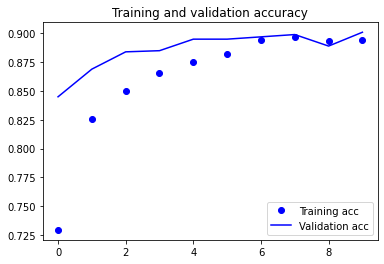

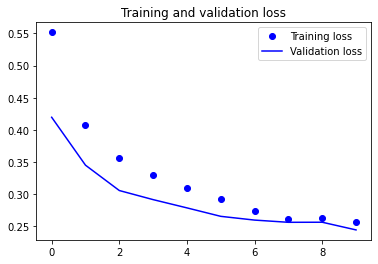

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine-Tunning


In [23]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [24]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [25]:
#======================================= 장시간 주의 ==================================
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/10
100/100 [==============================] - 329s 3s/step - loss: 0.2372 - acc: 0.9010 - val_loss: 0.2387 - val_acc: 0.8950
Epoch 2/10
100/100 [==============================] - 318s 3s/step - loss: 0.1993 - acc: 0.9180 - val_loss: 0.2003 - val_acc: 0.9170
Epoch 3/10
100/100 [==============================] - 297s 3s/step - loss: 0.1736 - acc: 0.9285 - val_loss: 0.1905 - val_acc: 0.9220
Epoch 4/10
100/100 [==============================] - 287s 3s/step - loss: 0.1432 - acc: 0.9455 - val_loss: 0.1954 - val_acc: 0.9210
Epoch 5/10
100/100 [==============================] - 284s 3s/step - loss: 0.1414 - acc: 0.9435 - val_loss: 0.1911 - val_acc: 0.9240
Epoch 6/10
100/100 [==============================] - 284s 3s/step - loss: 0.1232 - acc: 0.9580 - val_loss: 0.1815 - val_acc: 0.9270
Epoch 7/10
100/100 [==============================] - 284s 3s/step - loss: 0.1042 - acc: 0.9590 - val_loss: 0.2187 - val_acc: 0.9140
Epoch 8/10
100/100 [==============================] - 288s 3s/step - 

In [26]:
model.save('03_4_cats_and_dogs_vggfc_tunn.h5')

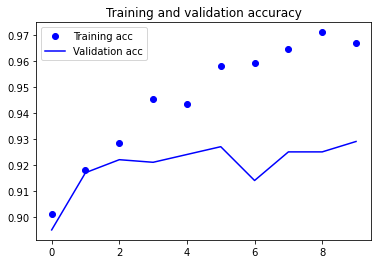

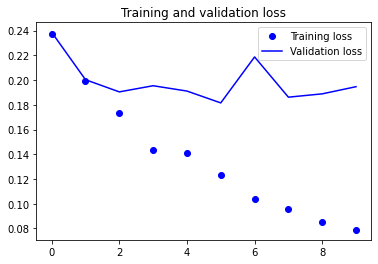

In [27]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Smooth Curve

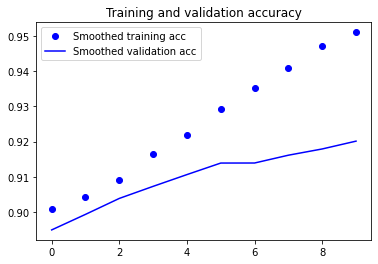

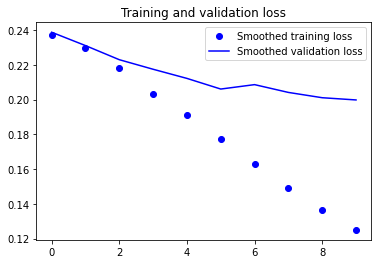

In [28]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.


Instructions for updating:
Please use Model.evaluate, which supports generators.


test acc: 0.925000011920929
